In [6]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [8]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [9]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [10]:
runs = [304125,302263,304508]
with open("pileup_data.pickle", 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 1
num_parts = 6

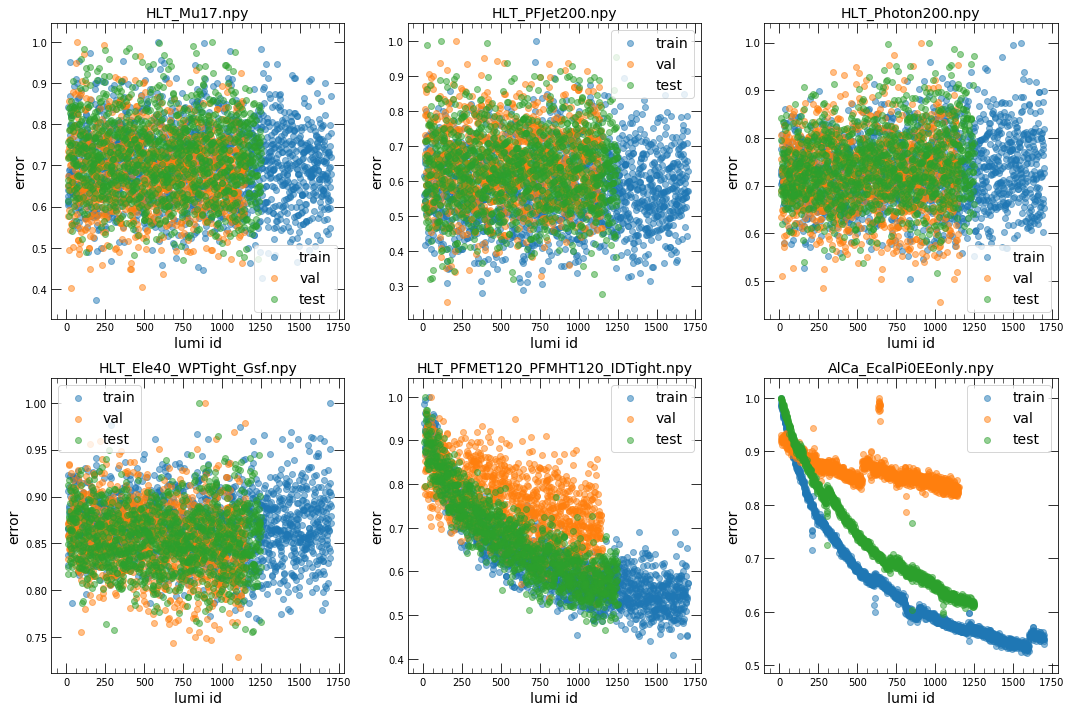

In [11]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
runs = [304125,304508,302263]

with open('pileup_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileup_bad_data.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad = np.array(bad_data['301480']['samples'])

WINDOW = 1

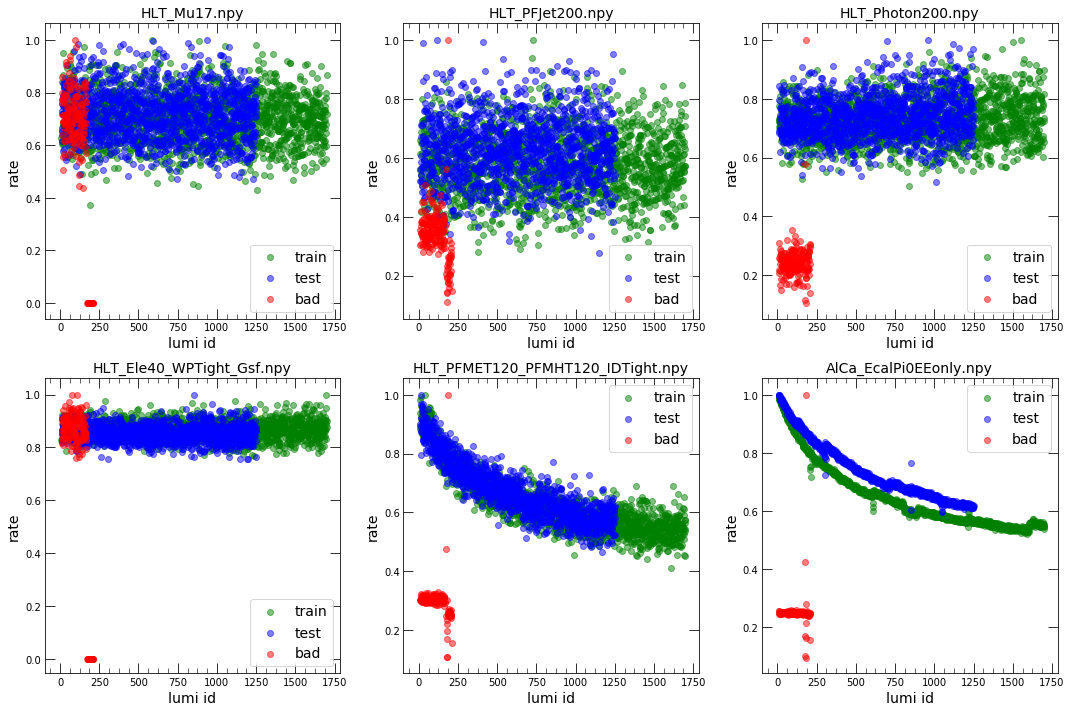

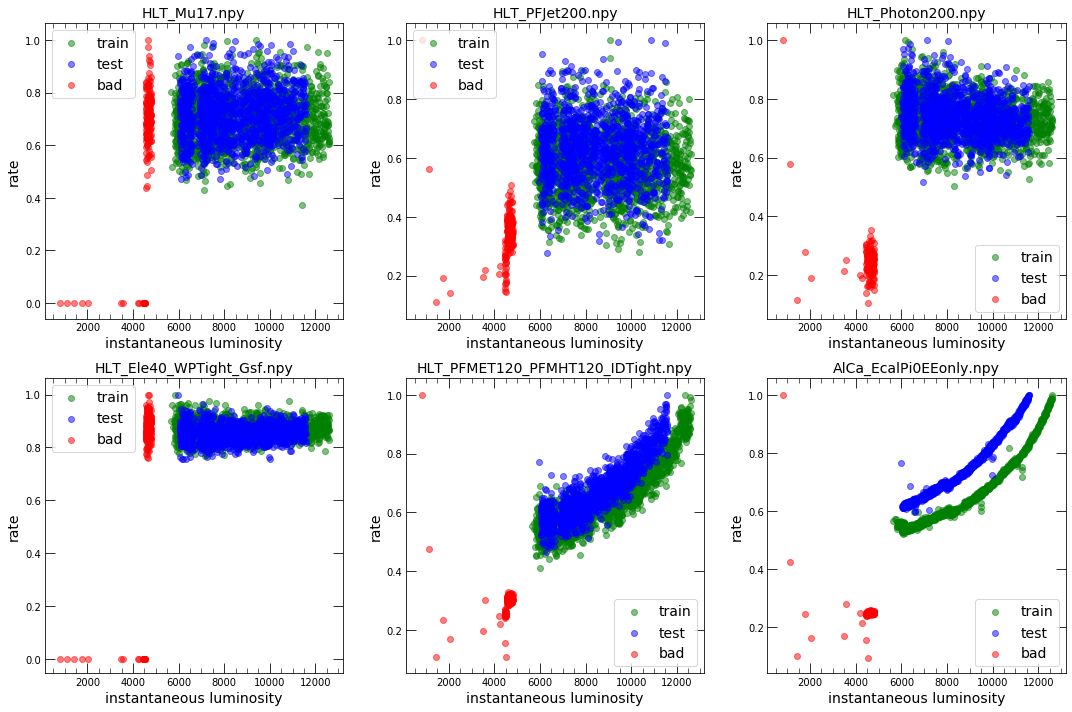

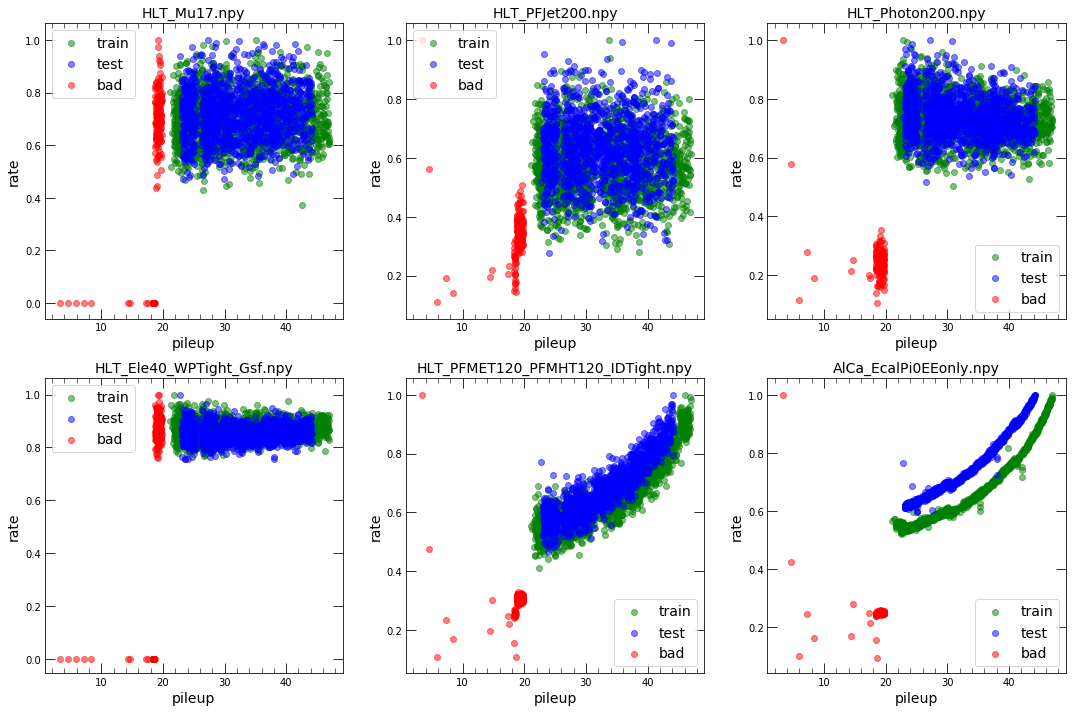

In [13]:
plots = [x_train,x_test,x_bad]
titles = ["train","test","bad"]

stuff = [[],[],[]]
lumi = [[],[],[]]
inst = [[],[],[]]
pileup = [[],[],[]]
for h in range(3):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    else:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r"]
    
plt.figure(figsize=[15,10])
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_parts):
    plt.subplot(2,3,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

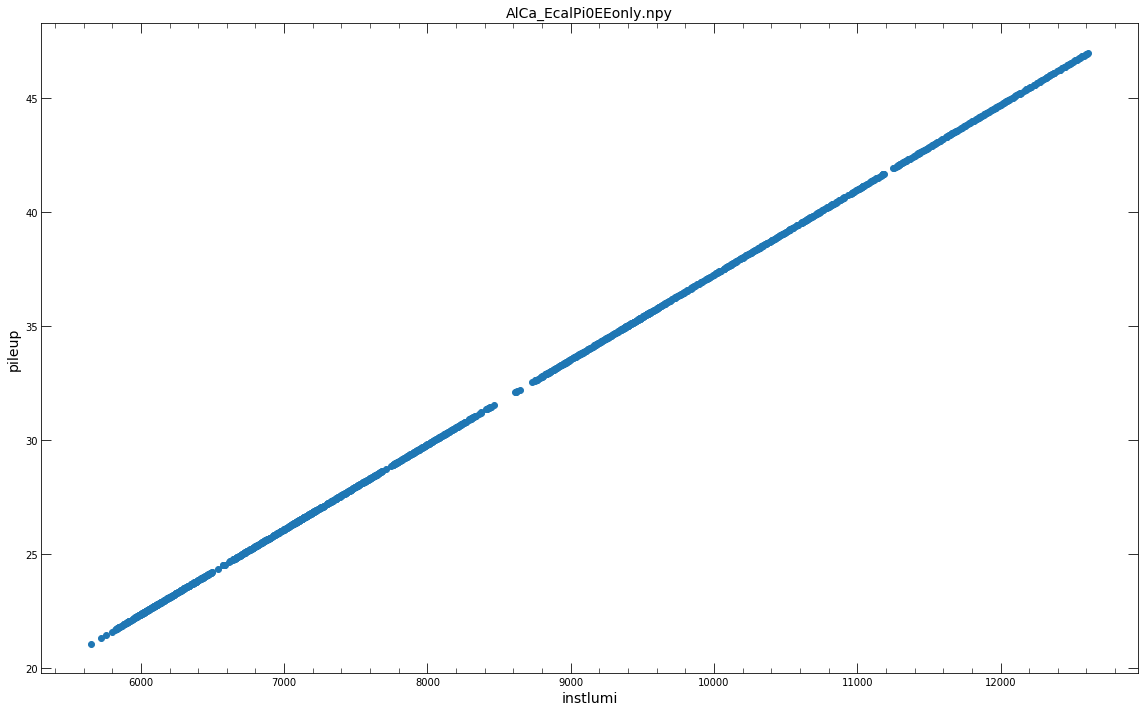

In [14]:
plt.figure()

plt.scatter(inst[0][0],pileup[0][0])
plt.xlabel('instlumi')
plt.ylabel('pileup')
plt.title(labels[i])

plt.tight_layout()

## Simple Autoencoder

In [15]:
model_name = "add_layer_max"


In [16]:
# Define the architecture

_input = Input(shape=(num_parts*WINDOW,), name="input")

mid = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="mid1")(_input)

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(mid)

mid = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="mid2")(hidden)

output = Dense(num_parts*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(mid)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
mid1 (Dense)                 (None, 5)                 35        
_________________________________________________________________
encoded (Dense)              (None, 3)                 18        
_________________________________________________________________
mid2 (Dense)                 (None, 5)                 20        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 36        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 0s - loss: 96231.0442 - val_loss: 101648.0650
Epoch 2/1000
 - 0s - loss: 91696.7898 - val_loss: 96841.5094
Epoch 3/1000
 - 0s - loss: 87391.3567 - val_loss: 92347.5414
Epoch 4/1000
 - 0s - loss: 83301.2444 - val_loss: 87966.4317
Epoch 5/1000
 - 0s - loss: 79353.9000 - val_loss: 83795.5004
Epoch 6/1000
 - 0s - loss: 75594.4696 - val_loss: 79831.1303
Epoch 7/1000
 - 0s - loss: 72012.7895 - val_loss: 76062.3552
Epoch 8/1000
 - 0s - loss: 68620.3061 - val_loss: 72494.6224
Epoch 9/1000
 - 0s - loss: 65402.1468 - val_loss: 69115.6782
Epoch 10/1000
 - 0s - loss: 62356.2082 - val_loss: 65902.3540
Epoch 11/1000
 - 0s - loss: 59464.8731 - val_loss: 62880.0966
Epoch 12/1000
 - 0s - loss: 56742.0662 - val_loss: 60008.2312
Epoch 13/1000
 - 0s - loss: 54157.4501 - val_loss: 57296.4348
Epoch 14/1000
 - 0s - loss: 51714.0369 - val_loss: 54752.0523
Epoch 15/1000
 - 0s - loss: 49423.2843 - val_loss: 52351.1699
Epoch 16/1000
 - 0s - loss: 47

Epoch 135/1000
 - 0s - loss: 3116.6628 - val_loss: 3387.2177
Epoch 136/1000
 - 0s - loss: 3076.4790 - val_loss: 3343.7535
Epoch 137/1000
 - 0s - loss: 3037.0478 - val_loss: 3301.0603
Epoch 138/1000
 - 0s - loss: 2998.2439 - val_loss: 3259.1248
Epoch 139/1000
 - 0s - loss: 2960.2826 - val_loss: 3218.0058
Epoch 140/1000
 - 0s - loss: 2922.9650 - val_loss: 3177.6413
Epoch 141/1000
 - 0s - loss: 2886.3016 - val_loss: 3138.0114
Epoch 142/1000
 - 0s - loss: 2850.3598 - val_loss: 3099.0577
Epoch 143/1000
 - 0s - loss: 2815.0257 - val_loss: 3060.8276
Epoch 144/1000
 - 0s - loss: 2780.3296 - val_loss: 3023.2781
Epoch 145/1000
 - 0s - loss: 2746.2645 - val_loss: 2986.3648
Epoch 146/1000
 - 0s - loss: 2712.7662 - val_loss: 2950.1298
Epoch 147/1000
 - 0s - loss: 2679.8786 - val_loss: 2914.5277
Epoch 148/1000
 - 0s - loss: 2647.5658 - val_loss: 2879.5437
Epoch 149/1000
 - 0s - loss: 2615.8493 - val_loss: 2845.1614
Epoch 150/1000
 - 0s - loss: 2584.6317 - val_loss: 2811.3516
Epoch 151/1000
 - 0s - l

Epoch 270/1000
 - 0s - loss: 849.4663 - val_loss: 927.4199
Epoch 271/1000
 - 0s - loss: 843.2433 - val_loss: 920.6464
Epoch 272/1000
 - 0s - loss: 837.0934 - val_loss: 913.9392
Epoch 273/1000
 - 0s - loss: 830.9951 - val_loss: 907.3043
Epoch 274/1000
 - 0s - loss: 824.9650 - val_loss: 900.7349
Epoch 275/1000
 - 0s - loss: 818.9932 - val_loss: 894.2321
Epoch 276/1000
 - 0s - loss: 813.0857 - val_loss: 887.7950
Epoch 277/1000
 - 0s - loss: 807.2381 - val_loss: 881.4248
Epoch 278/1000
 - 0s - loss: 801.4501 - val_loss: 875.1196
Epoch 279/1000
 - 0s - loss: 795.7261 - val_loss: 868.8781
Epoch 280/1000
 - 0s - loss: 790.0434 - val_loss: 862.7020
Epoch 281/1000
 - 0s - loss: 784.4375 - val_loss: 856.5861
Epoch 282/1000
 - 0s - loss: 778.8778 - val_loss: 850.5302
Epoch 283/1000
 - 0s - loss: 773.3734 - val_loss: 844.5348
Epoch 284/1000
 - 0s - loss: 767.9311 - val_loss: 838.6007
Epoch 285/1000
 - 0s - loss: 762.5358 - val_loss: 832.7270
Epoch 286/1000
 - 0s - loss: 757.1932 - val_loss: 826.91

Epoch 409/1000
 - 0s - loss: 361.7179 - val_loss: 395.5952
Epoch 410/1000
 - 0s - loss: 359.8423 - val_loss: 393.5479
Epoch 411/1000
 - 0s - loss: 357.9839 - val_loss: 391.5157
Epoch 412/1000
 - 0s - loss: 356.1326 - val_loss: 389.4987
Epoch 413/1000
 - 0s - loss: 354.3016 - val_loss: 387.4949
Epoch 414/1000
 - 0s - loss: 352.4781 - val_loss: 385.5064
Epoch 415/1000
 - 0s - loss: 350.6724 - val_loss: 383.5317
Epoch 416/1000
 - 0s - loss: 348.8752 - val_loss: 381.5717
Epoch 417/1000
 - 0s - loss: 347.0925 - val_loss: 379.6255
Epoch 418/1000
 - 0s - loss: 345.3232 - val_loss: 377.6925
Epoch 419/1000
 - 0s - loss: 343.5641 - val_loss: 375.7734
Epoch 420/1000
 - 0s - loss: 341.8202 - val_loss: 373.8673
Epoch 421/1000
 - 0s - loss: 340.0872 - val_loss: 371.9749
Epoch 422/1000
 - 0s - loss: 338.3666 - val_loss: 370.0958
Epoch 423/1000
 - 0s - loss: 336.6605 - val_loss: 368.2294
Epoch 424/1000
 - 0s - loss: 334.9607 - val_loss: 366.3768
Epoch 425/1000
 - 0s - loss: 333.2740 - val_loss: 364.53

Epoch 548/1000
 - 0s - loss: 190.9082 - val_loss: 208.9706
Epoch 549/1000
 - 0s - loss: 190.1267 - val_loss: 208.1177
Epoch 550/1000
 - 0s - loss: 189.3520 - val_loss: 207.2693
Epoch 551/1000
 - 0s - loss: 188.5801 - val_loss: 206.4257
Epoch 552/1000
 - 0s - loss: 187.8121 - val_loss: 205.5867
Epoch 553/1000
 - 0s - loss: 187.0486 - val_loss: 204.7523
Epoch 554/1000
 - 0s - loss: 186.2905 - val_loss: 203.9219
Epoch 555/1000
 - 0s - loss: 185.5340 - val_loss: 203.0966
Epoch 556/1000
 - 0s - loss: 184.7848 - val_loss: 202.2752
Epoch 557/1000
 - 0s - loss: 184.0371 - val_loss: 201.4587
Epoch 558/1000
 - 0s - loss: 183.2950 - val_loss: 200.6465
Epoch 559/1000
 - 0s - loss: 182.5563 - val_loss: 199.8389
Epoch 560/1000
 - 0s - loss: 181.8209 - val_loss: 199.0357
Epoch 561/1000
 - 0s - loss: 181.0911 - val_loss: 198.2368
Epoch 562/1000
 - 0s - loss: 180.3647 - val_loss: 197.4423
Epoch 563/1000
 - 0s - loss: 179.6406 - val_loss: 196.6521
Epoch 564/1000
 - 0s - loss: 178.9230 - val_loss: 195.86

Epoch 687/1000
 - 0s - loss: 113.4534 - val_loss: 124.2524
Epoch 688/1000
 - 0s - loss: 113.0641 - val_loss: 123.8264
Epoch 689/1000
 - 0s - loss: 112.6766 - val_loss: 123.4023
Epoch 690/1000
 - 0s - loss: 112.2906 - val_loss: 122.9802
Epoch 691/1000
 - 0s - loss: 111.9061 - val_loss: 122.5600
Epoch 692/1000
 - 0s - loss: 111.5244 - val_loss: 122.1416
Epoch 693/1000
 - 0s - loss: 111.1440 - val_loss: 121.7250
Epoch 694/1000
 - 0s - loss: 110.7649 - val_loss: 121.3103
Epoch 695/1000
 - 0s - loss: 110.3876 - val_loss: 120.8976
Epoch 696/1000
 - 0s - loss: 110.0114 - val_loss: 120.4868
Epoch 697/1000
 - 0s - loss: 109.6385 - val_loss: 120.0776
Epoch 698/1000
 - 0s - loss: 109.2662 - val_loss: 119.6703
Epoch 699/1000
 - 0s - loss: 108.8959 - val_loss: 119.2649
Epoch 700/1000
 - 0s - loss: 108.5269 - val_loss: 118.8614
Epoch 701/1000
 - 0s - loss: 108.1594 - val_loss: 118.4598
Epoch 702/1000
 - 0s - loss: 107.7946 - val_loss: 118.0597
Epoch 703/1000
 - 0s - loss: 107.4302 - val_loss: 117.66

Epoch 829/1000
 - 0s - loss: 71.9912 - val_loss: 78.8703
Epoch 830/1000
 - 0s - loss: 71.7757 - val_loss: 78.6346
Epoch 831/1000
 - 0s - loss: 71.5614 - val_loss: 78.3998
Epoch 832/1000
 - 0s - loss: 71.3479 - val_loss: 78.1659
Epoch 833/1000
 - 0s - loss: 71.1352 - val_loss: 77.9329
Epoch 834/1000
 - 0s - loss: 70.9231 - val_loss: 77.7008
Epoch 835/1000
 - 0s - loss: 70.7119 - val_loss: 77.4696
Epoch 836/1000
 - 0s - loss: 70.5011 - val_loss: 77.2394
Epoch 837/1000
 - 0s - loss: 70.2918 - val_loss: 77.0099
Epoch 838/1000
 - 0s - loss: 70.0833 - val_loss: 76.7812
Epoch 839/1000
 - 0s - loss: 69.8752 - val_loss: 76.5535
Epoch 840/1000
 - 0s - loss: 69.6680 - val_loss: 76.3266
Epoch 841/1000
 - 0s - loss: 69.4615 - val_loss: 76.1007
Epoch 842/1000
 - 0s - loss: 69.2559 - val_loss: 75.8755
Epoch 843/1000
 - 0s - loss: 69.0510 - val_loss: 75.6513
Epoch 844/1000
 - 0s - loss: 68.8467 - val_loss: 75.4278
Epoch 845/1000
 - 0s - loss: 68.6436 - val_loss: 75.2052
Epoch 846/1000
 - 0s - loss: 68

Epoch 973/1000
 - 0s - loss: 47.8794 - val_loss: 52.4664
Epoch 974/1000
 - 0s - loss: 47.7510 - val_loss: 52.3257
Epoch 975/1000
 - 0s - loss: 47.6231 - val_loss: 52.1855
Epoch 976/1000
 - 0s - loss: 47.4954 - val_loss: 52.0458
Epoch 977/1000
 - 0s - loss: 47.3684 - val_loss: 51.9066
Epoch 978/1000
 - 0s - loss: 47.2415 - val_loss: 51.7678
Epoch 979/1000
 - 0s - loss: 47.1153 - val_loss: 51.6295
Epoch 980/1000
 - 0s - loss: 46.9894 - val_loss: 51.4916
Epoch 981/1000
 - 0s - loss: 46.8641 - val_loss: 51.3542
Epoch 982/1000
 - 0s - loss: 46.7390 - val_loss: 51.2172
Epoch 983/1000
 - 0s - loss: 46.6145 - val_loss: 51.0807
Epoch 984/1000
 - 0s - loss: 46.4902 - val_loss: 50.9447
Epoch 985/1000
 - 0s - loss: 46.3664 - val_loss: 50.8092
Epoch 986/1000
 - 0s - loss: 46.2430 - val_loss: 50.6741
Epoch 987/1000
 - 0s - loss: 46.1201 - val_loss: 50.5394
Epoch 988/1000
 - 0s - loss: 45.9977 - val_loss: 50.4051
Epoch 989/1000
 - 0s - loss: 45.8756 - val_loss: 50.2713
Epoch 990/1000
 - 0s - loss: 45

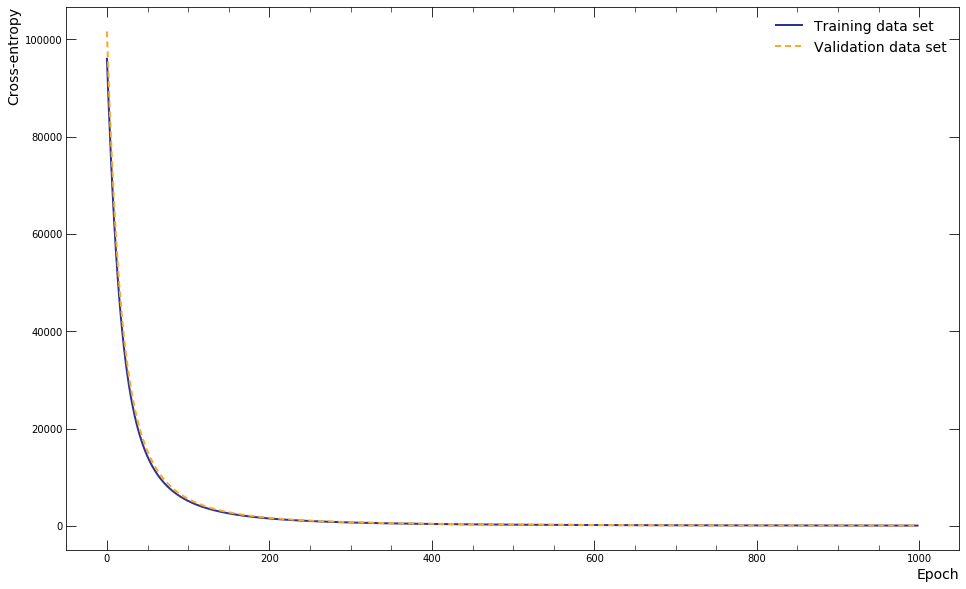

In [17]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

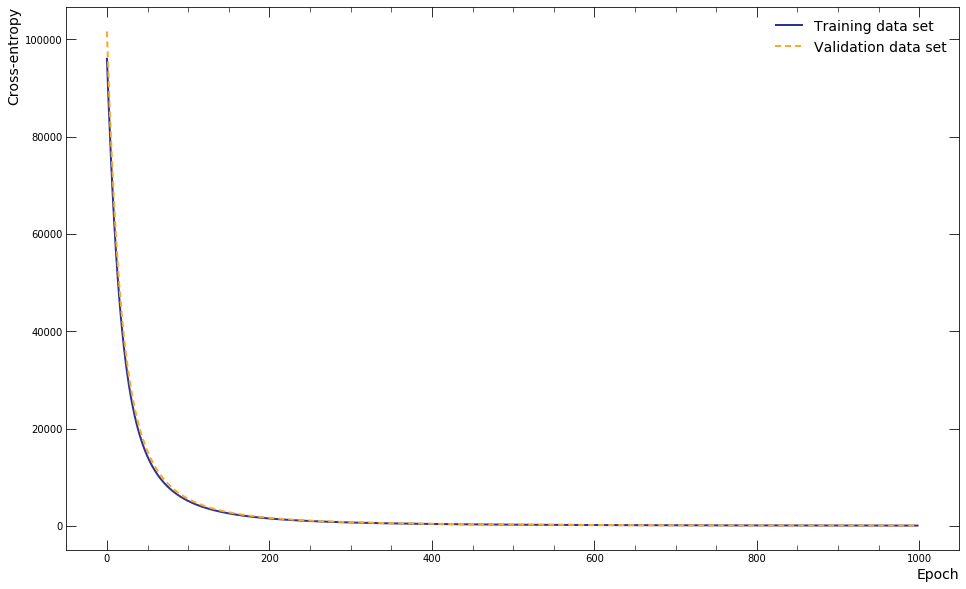

In [18]:
plot_loss(history)

## Training Set

In [19]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train_new))

error = abs(x_train_new-reconstructed)/x_train_new

In [20]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

1669 1669
1669 1669
1669 1669
1669 1669
1669 1669
1669 1669


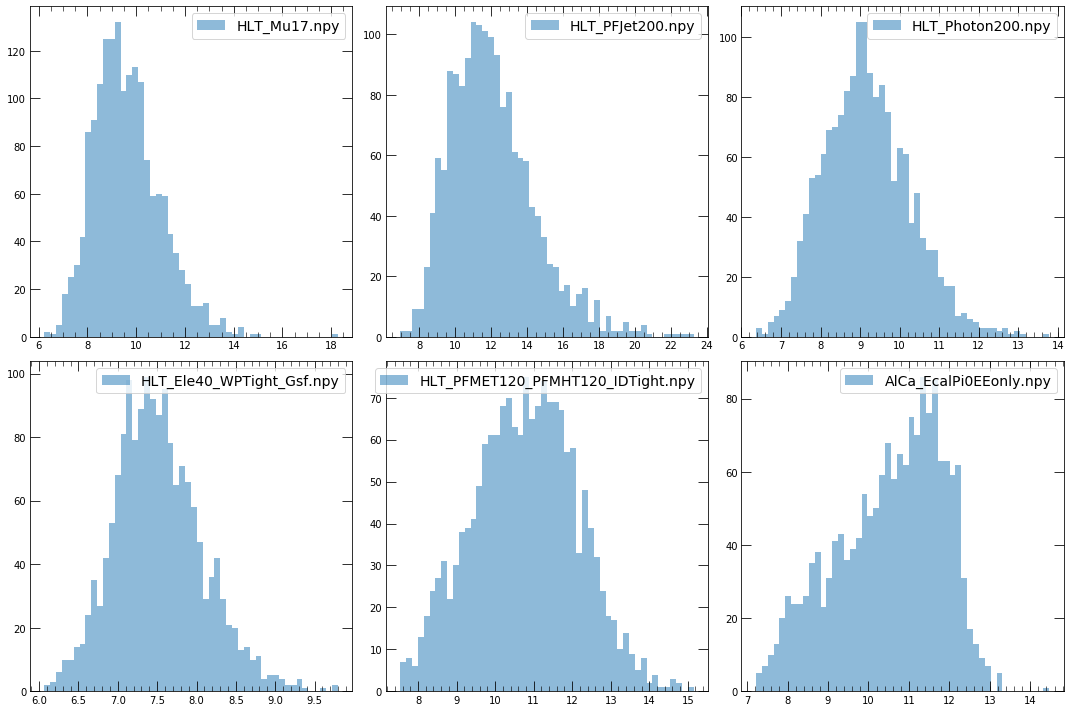

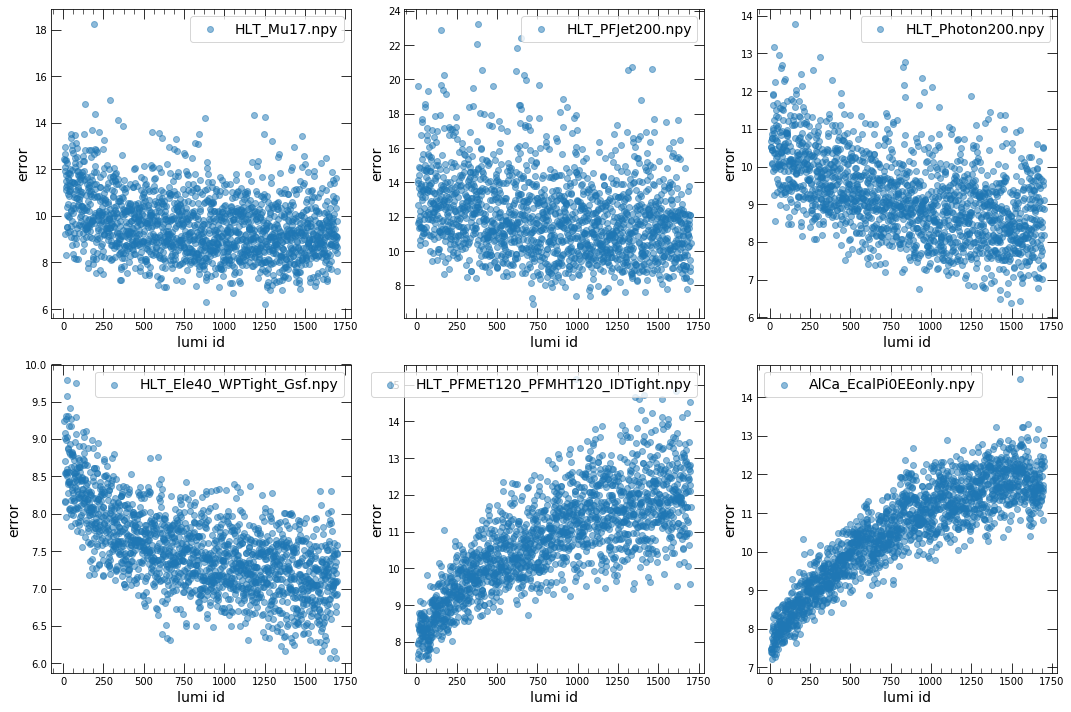

In [21]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    print(len(lumi),len(error_reformat[i]))
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()

plt.show()

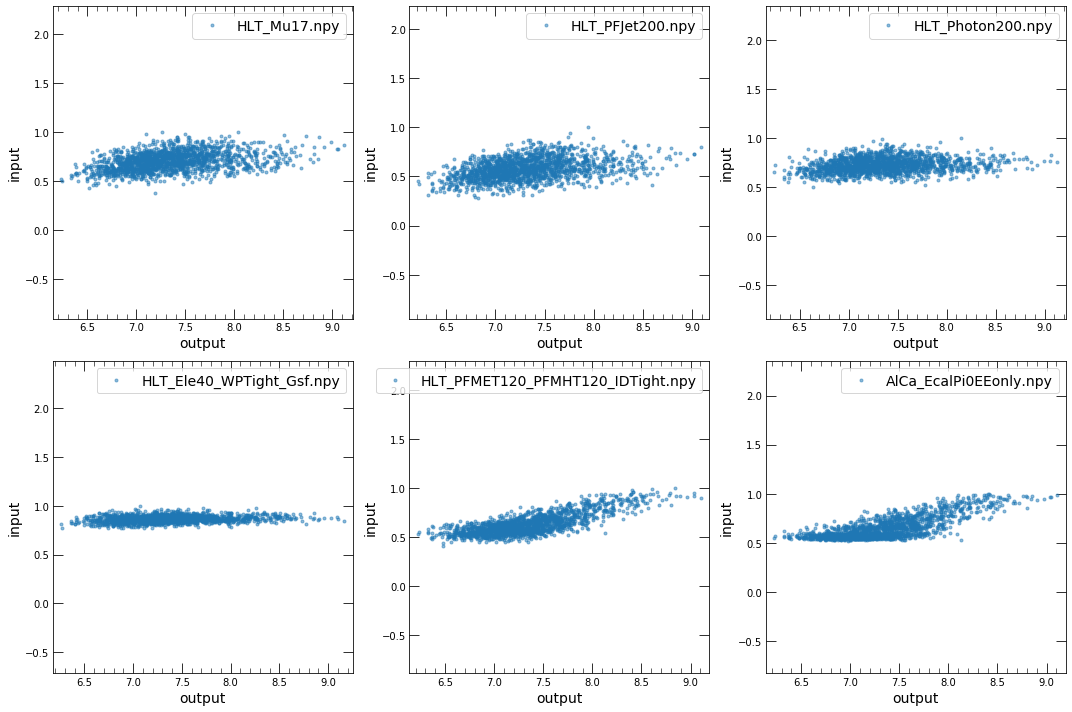

In [22]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.ylim(0,1.8)
    plt.legend()    
plt.tight_layout()
plt.show()

## Test Data

In [23]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [24]:
error_reformat = []
for i in range(num_parts):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(num_parts):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(num_parts):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(num_parts):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

1129 1129
1129 1129
1129 1129
1129 1129
1129 1129
1129 1129


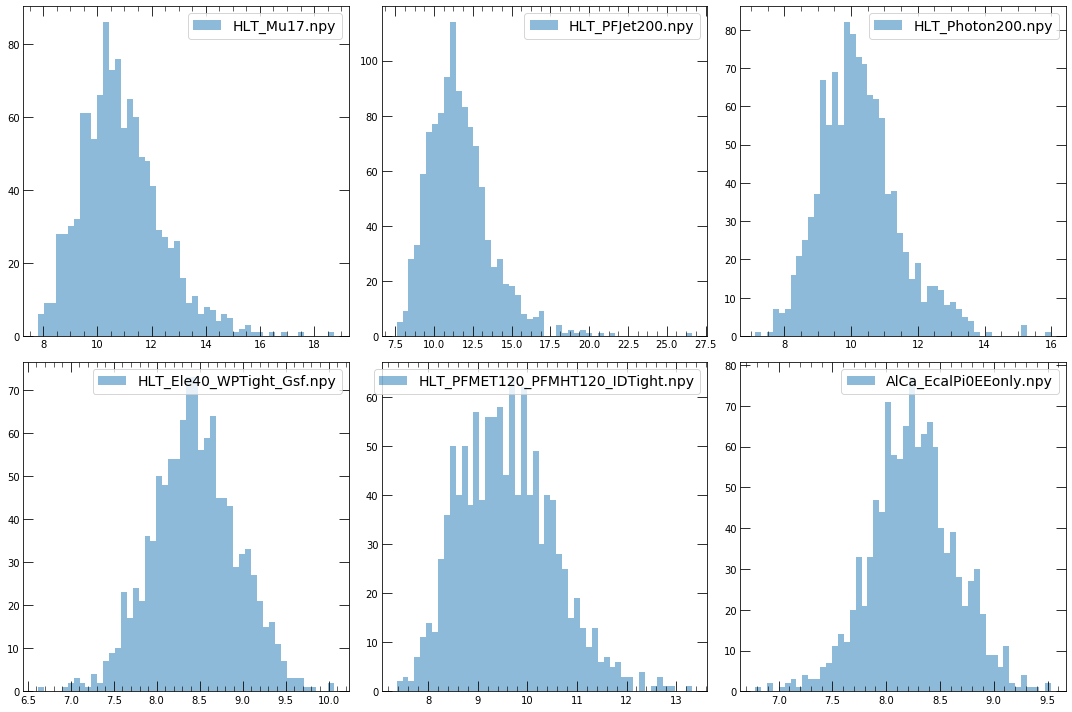

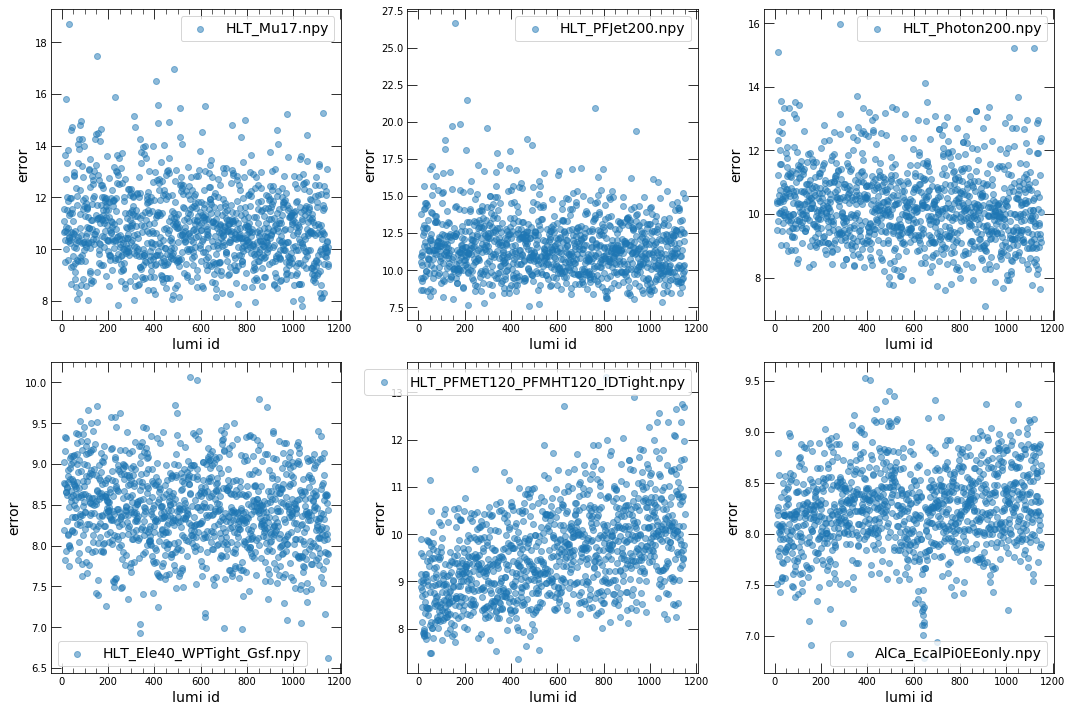

In [25]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    print(len(lumi),len(error_reformat[i]))
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()   
plt.tight_layout()

plt.show()

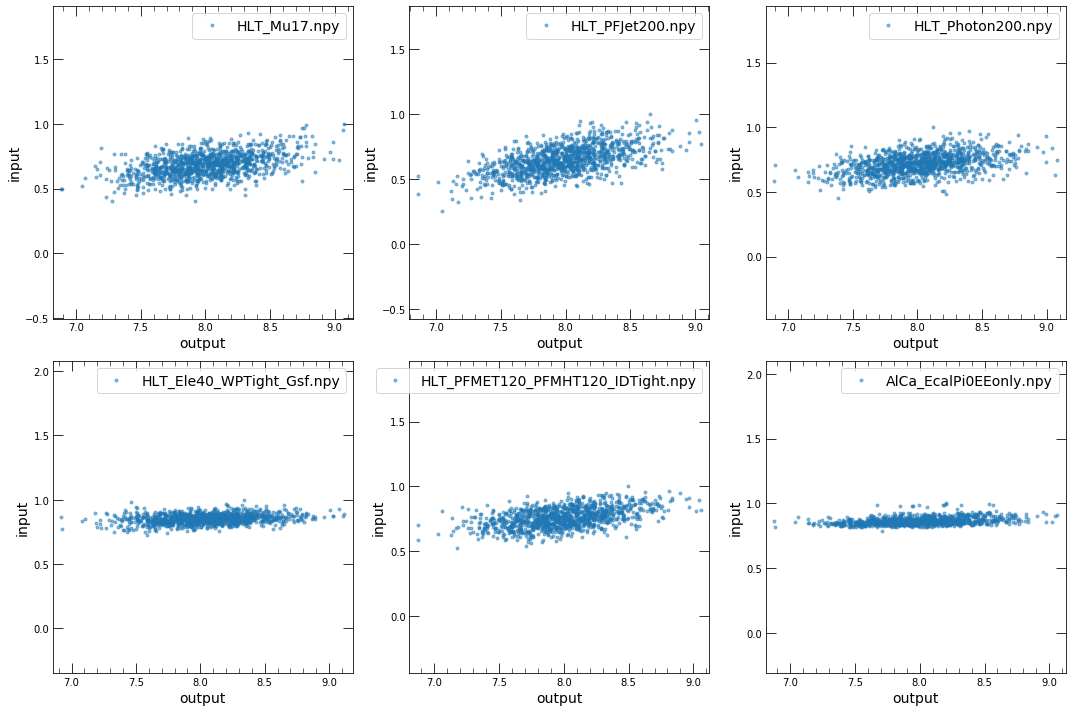

In [26]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('equal')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    
    
plt.tight_layout()

plt.show()

In [27]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [28]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [29]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [287]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [288]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


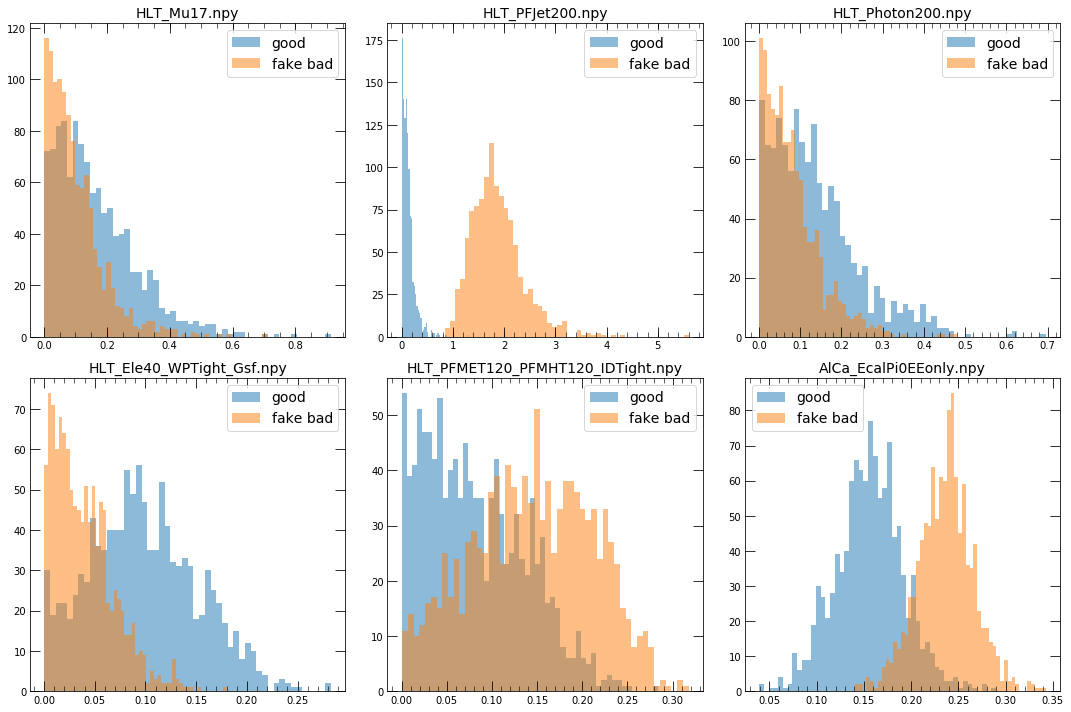

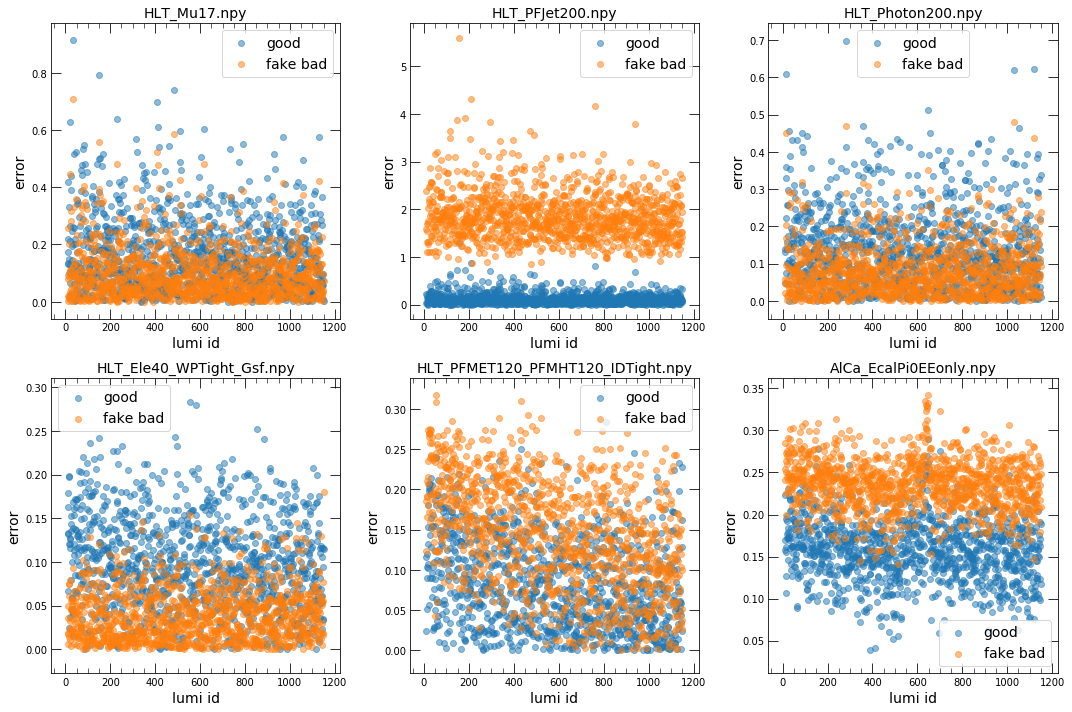

In [289]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

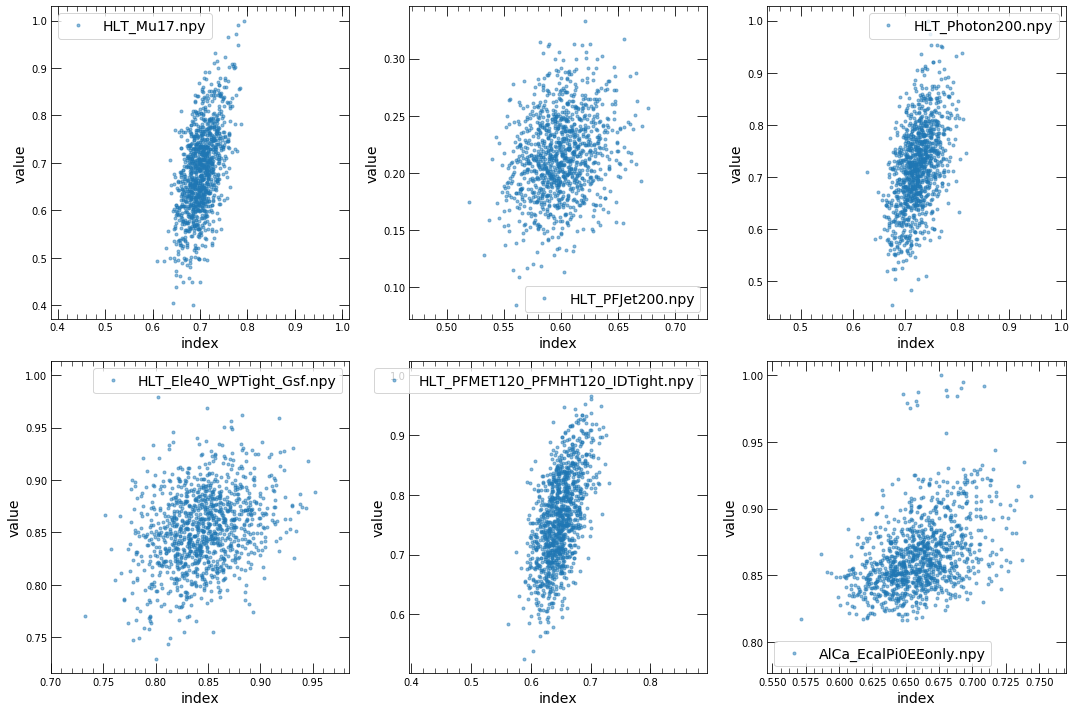

In [290]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [291]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [292]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [293]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [294]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [295]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


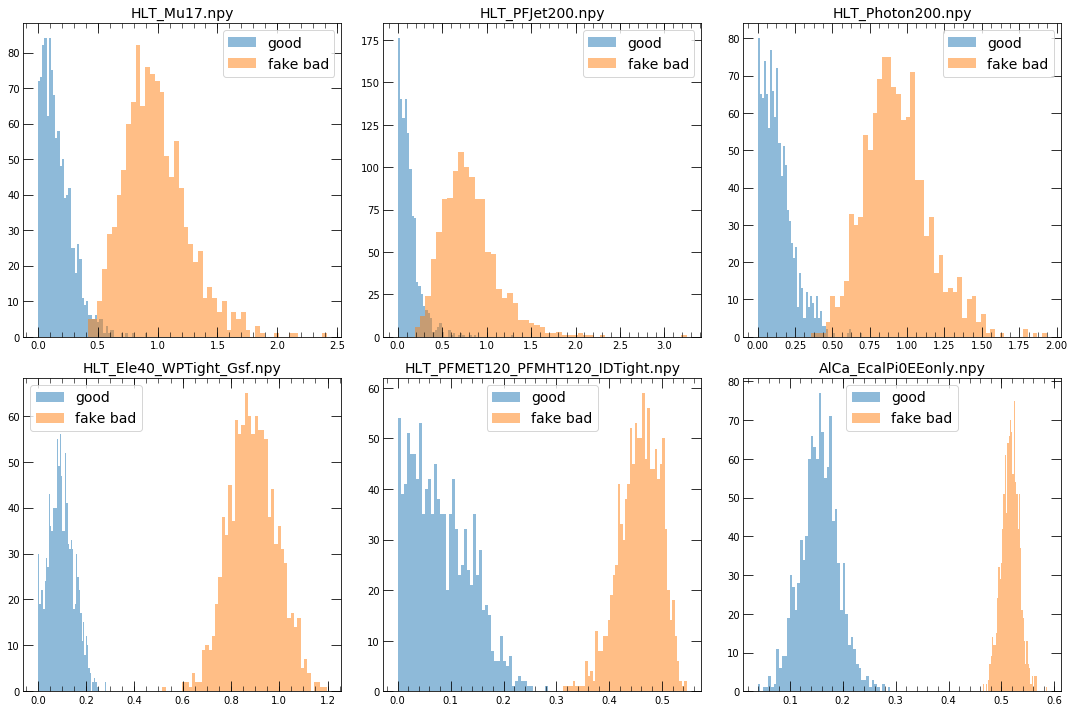

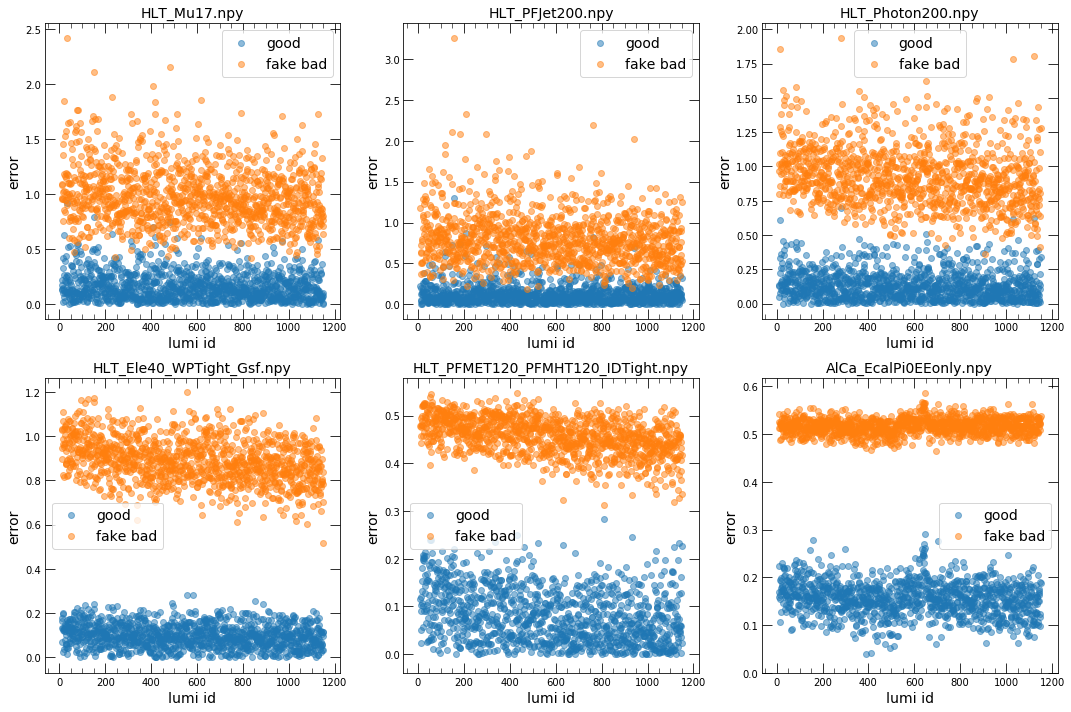

In [296]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
    
plt.tight_layout()

plt.show()

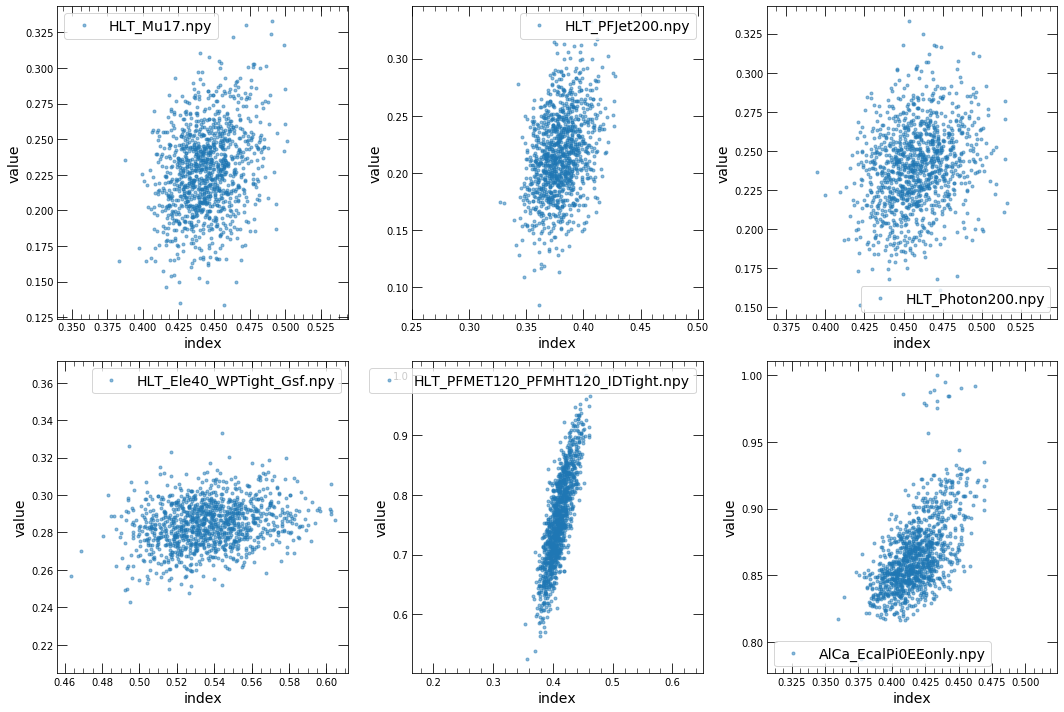

In [297]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()  
    
plt.tight_layout()

plt.show()

In [298]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [299]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [300]:
bad_runs = [301480]

with open("pileup_bad_data.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [301]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [302]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


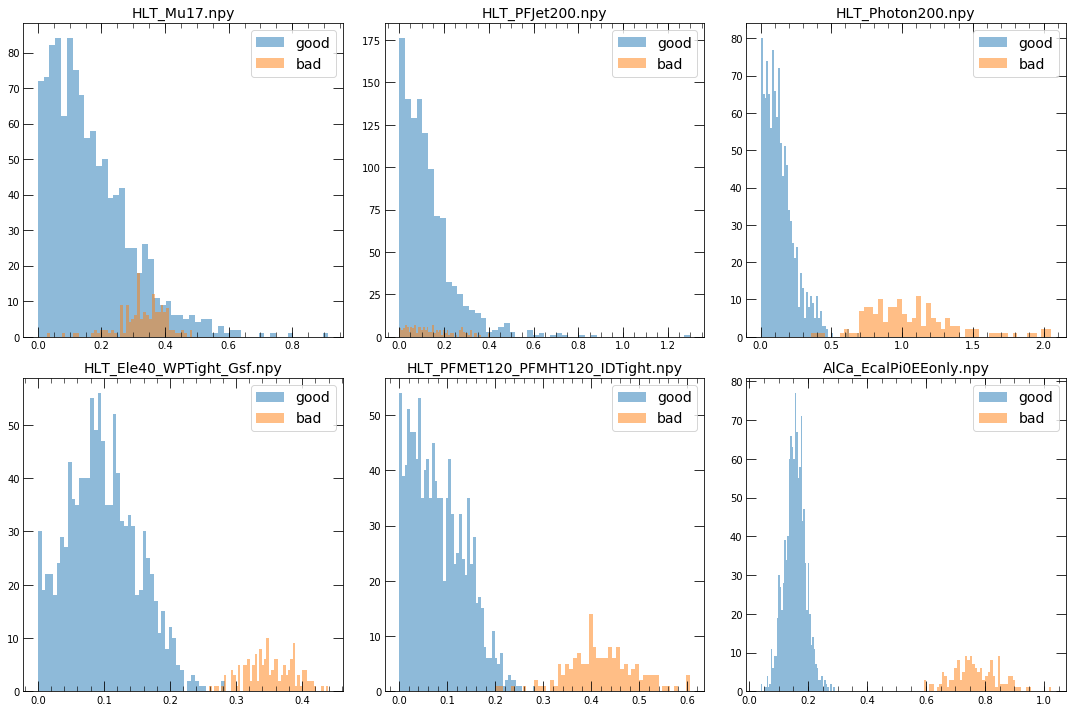

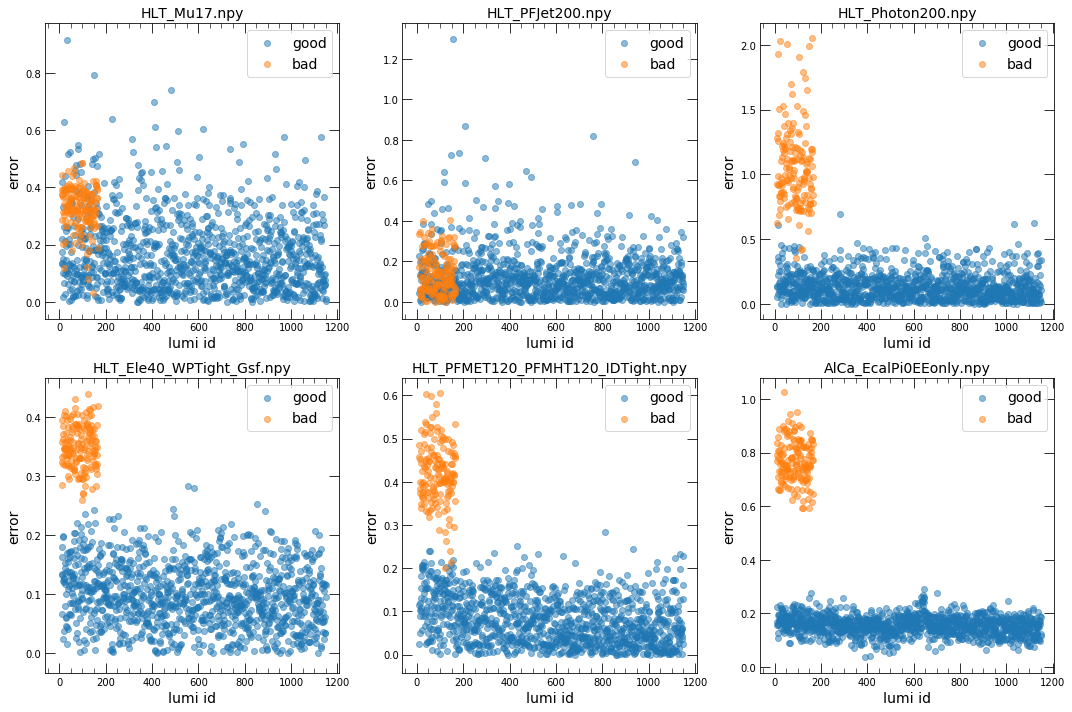

In [303]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

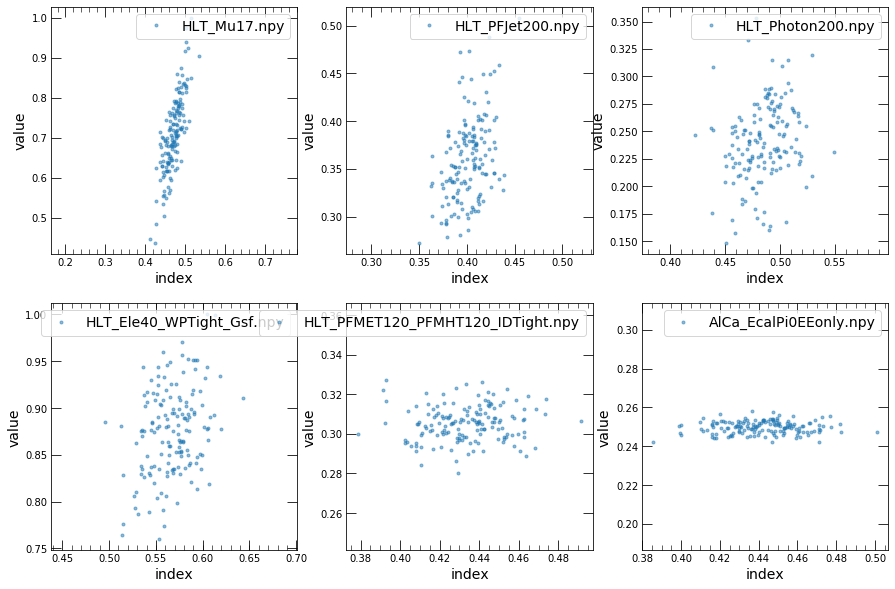

In [304]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [305]:
bad_runs = [305588]

with open("pileup_bad_data.pickle", 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [306]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [307]:
error_reformat_bad = []
for i in range(num_parts):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(num_parts):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(num_parts):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(num_parts):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


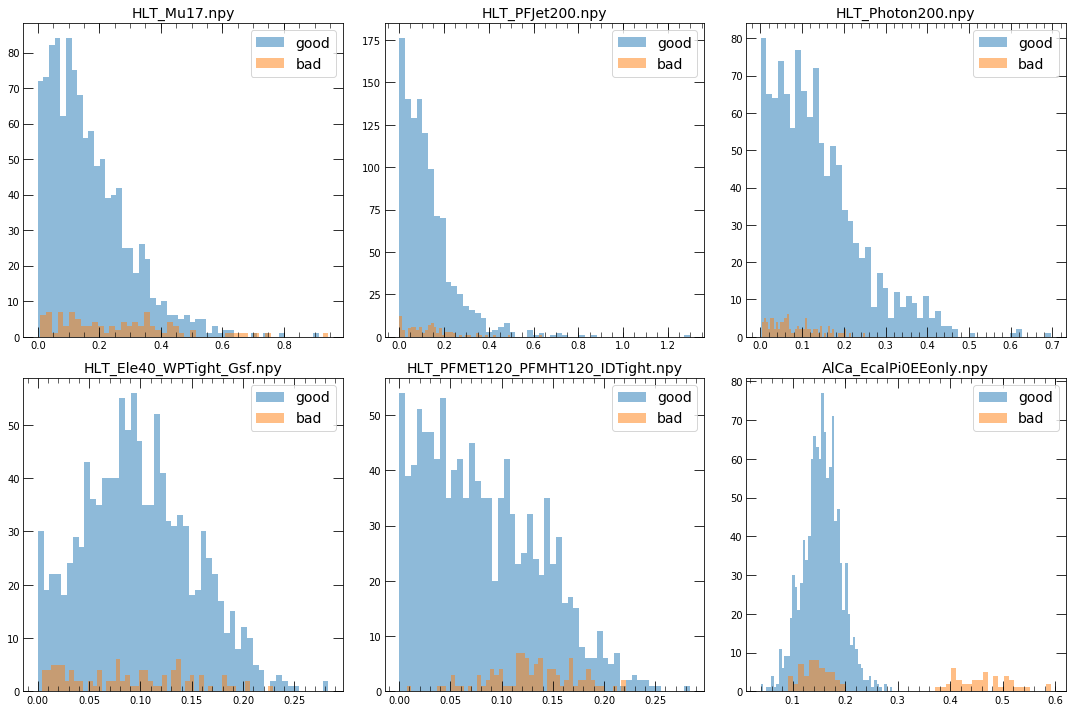

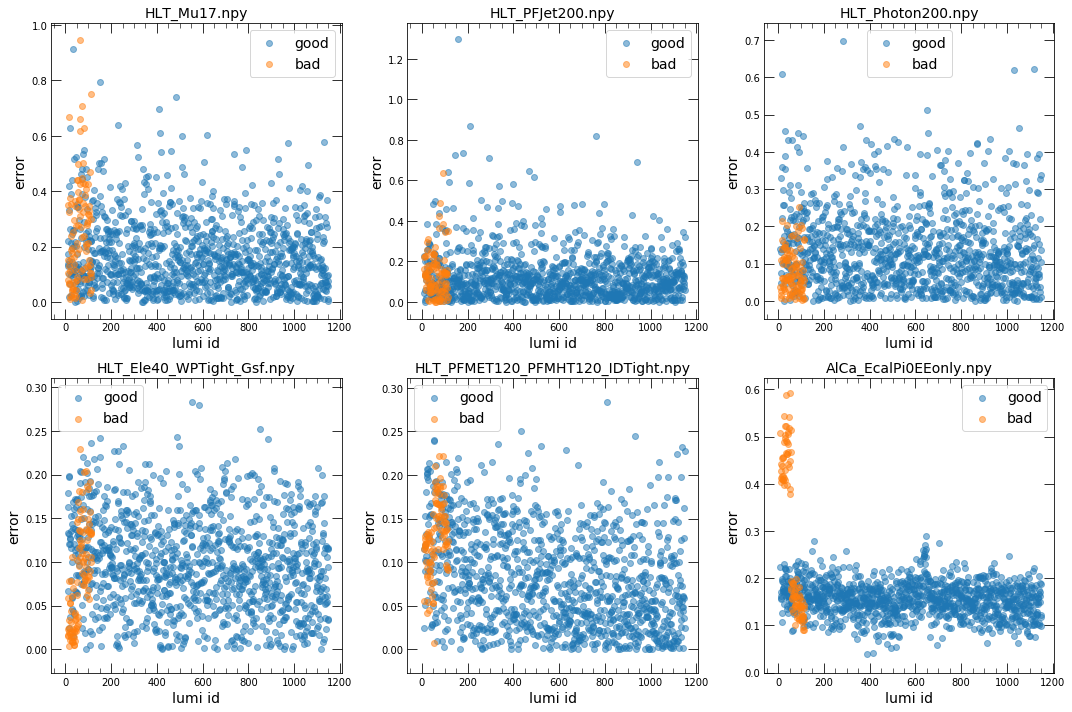

In [308]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()

plt.show()

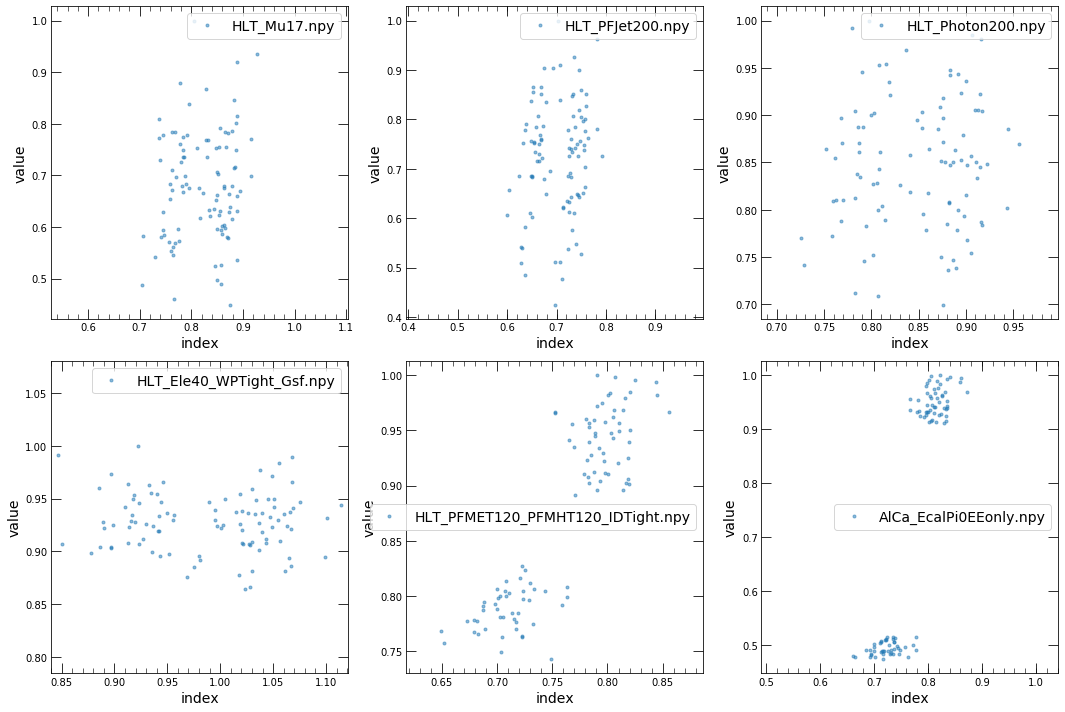

In [309]:
plt.figure(figsize=[15,10])
for i in range(0,num_parts):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.axis('equal')
    #plt.ylim(0,.6)
    plt.legend()   
plt.tight_layout()

plt.show()